In [41]:
# import necessary libraries
import pandas as pd
import collections
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
%matplotlib inline


# scikit learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
genre_dict = pickle.load(open("my_data_4/genre_dict","rb"))
all_categories = pickle.load(open("my_data_4/all_categories","rb")) 
major_categories = pickle.load(open("my_data_4/major_categories","rb")) 
minor_categories = pickle.load(open("my_data_4/minor_categories","rb")) 
df_oscars_wide = pd.read_csv('my_data_4/df_oscars_wide.csv', index_col=[0])
df_oscars_wide.title = df_oscars_wide.title.str.replace(':','')

award_columns = list(df_oscars_wide.columns[1:-1])
print('Award columns:\n', award_columns)

df_movies_main = pd.read_csv('my_data_4/DF_MEGA.csv',index_col=[0])
df_movies_main = df_movies_main[df_movies_main.imdbID.duplicated()==False]
df_movies_main.drop(['book','other','none'], axis=1, inplace=True)

df_movies_main_2019 = pd.read_csv('my_data_4/DF_MEGA_2019_updated.csv',index_col=[0])
filters_2019 = (df_movies_main_2019.dra==1)|(df_movies_main_2019.com==1)|(df_movies_main_2019.rom==1)|(df_movies_main_2019.epi==1)
filters_2019 = filters_2019 & (df_movies_main_2019.act==0)
df_movies_main_2019 = df_movies_main_2019[filters_2019]


# Only consider post 1960 movies
df_oscars_wide = df_oscars_wide[df_oscars_wide.year >= 1960]
df_movies_main = df_movies_main[df_movies_main.year >= 1960]

df_movies_main.title = df_movies_main.title.str.replace(':','')

print(df_movies_main.shape)
print(df_movies_main_2019.shape)
print("\nColumns:\n", df_movies_main.columns)
df_movies_main.head()


Award columns:
 ['actor', 'actress', 'art_direction', 'cinematography', 'costume', 'director', 'editing', 'effects', 'music', 'picture', 's_actor', 's_actress', 'screenplay', 'song', 'sound']
(4581, 49)
(157, 50)

Columns:
 Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'sup', 'hor',
       'com', 'spy', 'his', 'war', 'psy', 'rom', 'mon', 'fan', 'mus', 'pol',
       'bio', 'sci', 'act', 'dra', 'dis', 'adv', 'mys', 'thr', 'dys', 'cri',
       'epi', 'oth', 'ani', 'based_on_book', 'prescore', 'postscore',
       'precount_wins', 'precount_noms', 'win', 'nom'],
      dtype='object')


,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,genre,running_time,...,epi,oth,ani,based_on_book,prescore,postscore,precount_wins,precount_noms,win,nom
0,tt0097626,johnny handsome,1989,8324,6.2,20.0,7.24,7,3,96,...,0,0,0,1.0,0.4,0.0,0,2,0,0
1,tt0120903,x-men,2000,545484,7.4,75.0,296.30,10,4,104,...,0,0,0,1.0,5.4,0.0,1,2,0,0
2,tt0077975,national lampoon's animal house,1978,106817,7.5,3.0,141.60,6,1,109,...,0,0,0,0.0,0.0,0.0,0,0,0,0
3,tt1649419,the impossible,2012,182949,7.6,45.0,198.10,3,3,113,...,0,0,0,0.0,0.2,0.2,0,1,0,1
4,tt1099212,twilight,1998,401686,5.2,385.0,3346.00,18,3,607,...,0,0,0,1.0,0.0,0.0,0,0,0,0


In [4]:
# df_outcome = df_movies_main[['imdbID','title','year']]
df_movies_main = df_movies_main.merge(df_oscars_wide, on = ['title'], how='left').drop(columns='year_y').rename(columns = {'year_x':'year'})
df_movies_main.fillna('O', inplace=True)
df_movies_main = df_movies_main[df_movies_main.imdbID.duplicated()==False]

# Split into Data and Outcome
df_outcome = df_movies_main[['title'] + award_columns]
df_movies_main.drop(award_columns, axis=1, inplace=True)

print(df_movies_main.shape)
print(df_outcome.shape)
df_movies_main.tail()

(4581, 49)
(4581, 16)


,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,genre,running_time,...,epi,oth,ani,based_on_book,prescore,postscore,precount_wins,precount_noms,win,nom
4583,tt0452624,the good german,2006,23319,6.0,32.0,6.0,3,4,105,...,0,0,0,1.0,10.700000,0.0,3,7,0,0
4584,tt0497116,an inconvenient truth,2006,78298,7.4,1.5,49.8,1,2,97,...,0,0,0,0.0,0.400000,0.0,0,2,0,0
4585,tt0857191,the visitor,2008,40468,7.6,4.0,18.1,4,1,103,...,0,0,0,0.0,0.200000,0.2,0,1,0,1
4586,tt1667353,mirror mirror,2012,80479,5.6,85.0,183.0,7,5,106,...,0,1,0,1.0,5.800000,0.0,1,4,0,0
4587,tt4226388,victoria & abdul,2017,46625,7.7,21.0,65.4,6,5,111,...,0,0,0,1.0,7.136111,0.0,1,12,0,0


In [5]:
df_movies_main.columns

Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'sup', 'hor',
       'com', 'spy', 'his', 'war', 'psy', 'rom', 'mon', 'fan', 'mus', 'pol',
       'bio', 'sci', 'act', 'dra', 'dis', 'adv', 'mys', 'thr', 'dys', 'cri',
       'epi', 'oth', 'ani', 'based_on_book', 'prescore', 'postscore',
       'precount_wins', 'precount_noms', 'win', 'nom'],
      dtype='object')

# Learning from the Data

In [7]:
basic_ID_columns = ['imdbID', 'title', 'year']
genre_columns = ['genre', 'spy', 'sup', 'hor', 'dys', 'thr', 'act',
       'his', 'adv', 'dis', 'epi', 'com', 'fan', 'ani', 'mys', 'dra', 'psy',
       'mon', 'war', 'sci', 'mus', 'cri', 'oth', 'pol', 'rom', 'bio',
       'based_on_book']
imdb_columns = ['cast', 'n_votes', 'imdb_rating']
pre_oscar_columns = ['prescore', 'precount_wins', 'precount_noms']
post_oscar_columns = ['postscore', 'win', 'nom']
derived_columns = ['budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings']
budget_columns = ['budget', 'inflation_factor','budget_adjusted']
box_office_columns = ['box_office']


In [8]:
def convert_to_pctile(X):
    for col in X.columns:
        x = np.array(X[col])
        X[col] = [(len(np.where(x<=y)[0])/len(x)) for y in x]
    return X

def top_N_each_year(df,N,feature):
    df_ = pd.DataFrame()
    for year in list(set(df.year)):
        # print(year)
        df_ = df_.append(df[df.year == year].sort_values(by = feature, ascending=False).head(N))
    return df_

In [10]:
#Define predictors
all_predictors = ['imdbID', 'title', 'year', 'imdb_rating',
       'cast', 'precount_wins', 'precount_noms', 'prescore', 'running_time']  + genre_columns # +  ['percent_revenue']

# Get training ad testing data
X = df_movies_main[all_predictors].drop(['imdbID', 'title', 'year'], axis=1)
X_2019 = df_movies_main_2019[all_predictors].drop(['imdbID', 'title', 'year'], axis=1)
print(X.shape)
print(X_2019.shape)

# Target
y = (df_outcome.picture == 'N') | (df_outcome.director== 'N')
y = np.array([int(z) for z in y])
print(y.shape)
y = np.expand_dims(y, axis=1)
print("Number of movies in the 1-class:,",len(np.where(y==1)[0]))

# Copnvert to Percentile
X = convert_to_pctile(X)
X_2019 = convert_to_pctile(X_2019)

(4581, 33)
(157, 33)
(4581,)
Number of movies in the 1-class:, 292


# Logistic Regression

In [ ]:
log = LogisticRegression(random_state=0)
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
log_cv = GridSearchCV(log, hyperparameters, cv=5, verbose=0)
log_cv.fit(X, y)
y_pred = log_cv.predict(X_2019)
y_proba = log_cv.predict_proba(X_2019)[:,1]
print(log_cv.score(X, y))
df_movies_main_2019.loc[:,'predicted_probability_log'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_log', ascending=False).head(10)
# print(knn_cv.best_params_)
clear_output()
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_log'])
plt.xlabel('probability')

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

## K Nearest neighbors classifier

{'n_neighbors': 10}


Text(0.5, 0, 'probability')

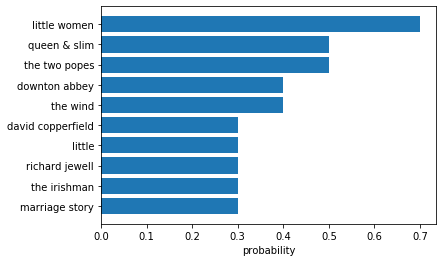

In [125]:

# KNN Training
knn = KNeighborsClassifier(n_neighbors=5)
param_grid = {'n_neighbors': np.arange(1, 30)} 
knn_cv = GridSearchCV(knn, param_grid, cv=5) 
# knn.fit(X, y) 
knn_cv.fit(X, y)

# KNN prediction
y_pred = knn_cv.predict(X_2019)
y_prob = knn_cv.predict_proba(X_2019)
df_movies_main_2019.loc[:,'predicted_probability_knn'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_knn', ascending=False).head(10)
print(knn_cv.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_knn'])
plt.xlabel('probability')


## Random Forest Classifier

{'n_estimators': 90}


Text(0.5, 0, 'probability')

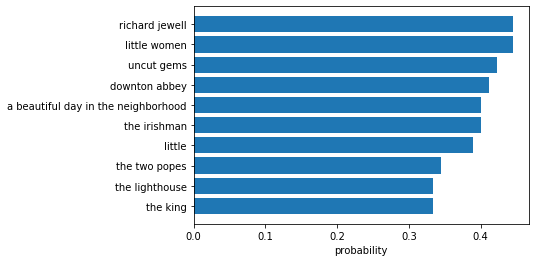

In [126]:
rfc=RandomForestClassifier() # n_estimators=100)
param_grid = {'n_estimators': np.arange(50,100,5)} 
rfc_cv = GridSearchCV(rfc, param_grid, cv=5) 

rfc_cv.fit(X,y)
y_pred = rfc_cv.predict(X_2019)
y_prob = rfc_cv.predict_proba(X_2019)
df_movies_main_2019.loc[:,'predicted_probability_rfc'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_rfc', ascending=False).head(10)
print(rfc_cv.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_rfc'])
plt.xlabel('probability')



### Decision Tree Regressor

In [106]:
sample_split = list(range(2, 20))
param_grid = dict(min_samples_split=sample_split)
reg = DecisionTreeRegressor(random_state = 47)
reg_cv = GridSearchCV(reg, param_grid, cv=5) 
reg_cv.fit(X,y)
y_pred=reg_cv.predict(X_2019)
# y_prob = reg_cv.predict_proba(X_2019)
# df_movies_main_2019.loc[:,'predicted_probability'] = y_prob[:,1]
# df_movies_main_2019[['imdbID','title','year','predicted_probability']][y_pred == 1].sort_values(by = 'predicted_probability',
                                                                                               # ascending=False)

df_movies_main_2019[['imdbID','title','year']][y_pred == 1]

,imdbID,title,year
145,tt2584384,jojo rabbit,2019
156,tt7653254,marriage story,2019


## Ensemble Method

Text(0.5, 0, 'probability')

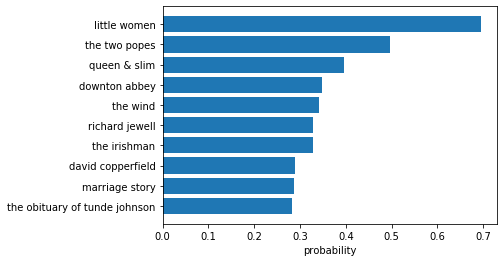

In [127]:
bag = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10), n_estimators=100, random_state=42).fit(X, y)
y_pred = bag.predict(X_2019)
y_prob = bag.predict_proba(X_2019)
df_movies_main_2019.loc[:,'predicted_probability_bag'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_bag', ascending=False).head(10)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_bag'])
plt.xlabel('probability')



# Adaboost

Text(0.5, 0, 'probability')

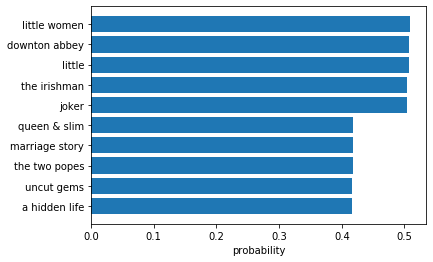

In [128]:
ada = AdaBoostClassifier(n_estimators=100, random_state=47)
ada.fit(X, y)
y_pred = ada.predict(X_2019)
y_prob = ada.predict_proba(X_2019)

df_movies_main_2019.loc[:,'predicted_probability_ada'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_ada', ascending=False).head(10)
# print(bag.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_ada'])
plt.xlabel('probability')


# Neural Network

Text(0.5, 0, 'probability')

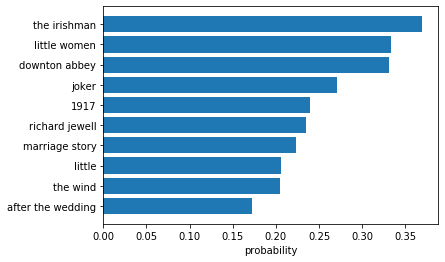

In [129]:
mlp = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5,5), max_iter=1000, random_state=41)
mlp.fit(X, y)
y_pred = mlp.predict(X_2019)
y_prob = mlp.predict_proba(X_2019)
# print(y_prob)
# print(classifier.score)
df_movies_main_2019.loc[:,'predicted_probability_mlp'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_mlp', ascending=False).head(10)
# print(bag.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_mlp'])
plt.xlabel('probability')


# Ensemble of Neural Networks

Text(0.5, 0, 'probability')

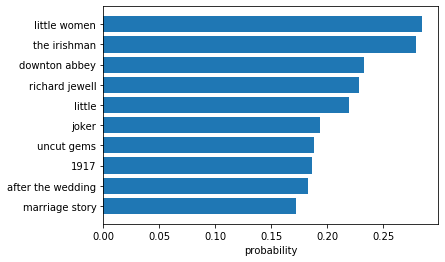

In [130]:
mlp = MLPClassifier(solver='sgd')
mlp_bag = BaggingClassifier(base_estimator=mlp, n_estimators=100, random_state=42).fit(X, y)
y_pred = mlp_bag.predict(X_2019)
y_prob = mlp_bag.predict_proba(X_2019)
df_movies_main_2019.loc[:,'predicted_probability_mlpbag'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_mlpbag', ascending=False).head(10)
# print(bag.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_mlpbag'])
plt.xlabel('probability')




# df_movies_main_2019.loc[:,'predicted_probability_mlpbag'] = y_prob[:,1]
# # df_movies_main_2019[['imdbID','title','year','predicted_probability']][y_pred == 1]
# df_movies_main_2019[['imdbID','title','year','predicted_probability']].sort_values(by = 'predicted_probability',
#                                                                                                ascending=False)
# clear_output()
# df_movies_main_2019[['imdbID','title','year','predicted_probability']].sort_values(by = 'predicted_probability',
#                                                                                    ascending=False).head(10)
                                                                                   

In [114]:
df_movies_main_2019.columns

Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'book', 'sup',
       'hor', 'com', 'spy', 'his', 'war', 'psy', 'rom', 'mon', 'fan', 'mus',
       'pol', 'bio', 'sci', 'act', 'dra', 'dis', 'adv', 'mys', 'thr', 'dys',
       'cri', 'epi', 'oth', 'ani', 'based_on_book', 'other', 'prescore',
       'postscore', 'precount_wins', 'precount_noms', 'box_office_adjusted',
       'predicted_probability', 'predicted_probability_rfc',
       'predicted_probability_knn', 'predicted_probability_bag',
       'predicted_probability_ada', 'predicted_probability_mlp',
       'predicted_probability_mlpbag'],
      dtype='object')

# The Grand Average Prediction

Text(0, 0.5, 'probability')

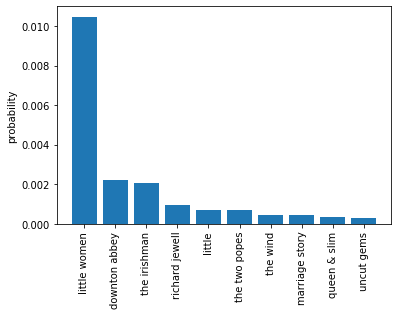

In [131]:
df_movies_main_2019['final_proba'] = df_movies_main_2019[['predicted_probability_rfc',
       'predicted_probability_knn', 'predicted_probability_bag',
       'predicted_probability_ada', 'predicted_probability_mlp',
       'predicted_probability_mlpbag']].prod(axis=1)
df_movies_main_2019.columns
x = df_movies_main_2019.sort_values(by='final_proba', ascending=False).head(10)
# print(bag.best_params_)
# x = x.iloc[::-1,:]
plt.bar(x['title'], x['final_proba'])
plt.xticks(rotation=90)
plt.ylabel('probability')

